In [1]:
from proglearn.progressive_learner import ClassificationProgressiveLearner
from proglearn.transformers import TreeClassificationTransformer
from proglearn.voters import TreeClassificationVoter
from proglearn.deciders import SimpleArgmaxAverage

from sklearn.tree import DecisionTreeClassifier
from joblib import Parallel, delayed
from collections import defaultdict
from sklearn.utils.fixes import _joblib_parallel_args
import threading
from sklearn.ensemble._base import _partition_estimators
from sklearn.utils.validation import check_is_fitted

import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.validation import check_X_y, check_array


from hyppo.tools import multimodal_independence, indep_sim, rot_ksamp
from hyppo.tools import SIMULATIONS
from hyppo.ksample._utils import k_sample_transform
from tqdm import tqdm
from hyppo.tools import * 

from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal


import matplotlib.pyplot as plt

In [2]:
class UncertaintyForest:
    """
    A class used to represent an Uncertainty Forest.
    Parameters
    ----------
    n_estimators : int, default=100
        The number of trees in the UncertaintyForest
    kappa : float, default=np.inf
        The coefficient for finite sample correction. If set to the default
        value, finite sample correction is not performed.
    max_depth : int, default=None
        The maximum depth of a tree in the UncertaintyForest.
    tree_construction_proportion : float, default=0.5
        The proportions of the input data set aside to train each decision
        tree. The remainder of the data is used to fill in voting posteriors.
    max_features : {"auto", "sqrt", "log2"}, int or float, default="auto"
        The number of features to consider when looking for the best split:
        - If int, then consider `max_features` features at each split.
        - If float, then `max_features` is a fraction and
          `round(max_features * n_features)` features are considered at each
          split.
        - If "auto", then `max_features=sqrt(n_features)`.
        - If "sqrt", then `max_features=sqrt(n_features)` (same as "auto").
        - If "log2", then `max_features=log2(n_features)`.
        - If None, then `max_features=n_features`.
        Note: the search for a split does not stop until at least one
        valid partition of the node samples is found, even if it requires to
        effectively inspect more than ``max_features`` features.
    poisson_sampler : boolean, default=False
        To match the GRF theory [#1grf]_, if True, the number of features
        considered at each tree are drawn from a poisson distribution with
        mean equal to `max_features`.
    n_jobs : int, default=None
        The number of jobs to run in parallel. ``-1`` means use all
        processors. None equates to 1.
    max_samples : int or float, default=None
        The number of samples to draw from X (without replacement) to train
        each tree.
        - If None, then draw `X.shape[0]` samples.
        - If int, then draw `max_samples` samples.
        - If float, then draw `max_samples * X.shape[0]` samples. Thus,
          `max_samples` should be in the interval `(0, 1)`.
        Note: The number of samples used to learn the tree will be further
        reduced per the `tree_construction_proportion` value.
    honest_prior : {"ignore", "uniform", "empirical"}, default="ignore"
        Method for dealing with empty leaves during evaluation of a test
        sample. If "ignore", trees in which the leaf is empty are not used in
        the prediction. If "uniform", the prior tree posterior is 1/(number of
        classes). If "empirical", the prior tree posterior is the relative
        class frequency in the voting subsample. If all tree leaves are empty,
        "ignore" will use the empirical prior and the others will use their
        respective priors.
    tree_kwargs : dict, default={}
        Named arguments to be passed to each
        sklearn.tree.DecisionTreeClassifier tree used in the construction
        of the forest in addition to the above parameters.
    Attributes
    ----------
    transformers_ : list of sklearn.tree.DecisionTreeClassifier
        The collection of fitted trees.
    voters_ : list of proglearn.voter.TreeClassificationVoter
        The collection of honest voters for leaves in matching trees in
        `self.estimators_` at the same index.
    n_features_ : int
        The number of features when `fit` is performed.
    tree_kwargs_ : dict
        Full set of keyword arguments passed to the Forest transformer.
    References
    ----------
    .. [#1grf] Athey, Susan, Julie Tibshirani and Stefan Wager.
        "Generalized Random Forests", Annals of Statistics, 2019.
    """

    def __init__(
        self,
        n_estimators=100,
        kappa=np.inf,
        max_depth=None,
        tree_construction_proportion=0.63,
        max_features="auto",
        poisson_sampler=False,
        max_samples=None,
        n_jobs=None,
        honest_prior="ignore",
        weighted_trees=False,
        min_samples_leaf=1,
        min_samples_split=2,
        min_impurity_decrease=0.0,
    ):
        self.n_estimators = n_estimators
        self.kappa = kappa
        self.max_depth = max_depth
        self.tree_construction_proportion = tree_construction_proportion
        self.max_features = max_features
        self.poisson_sampler = poisson_sampler
        self.max_samples = max_samples
        self.n_jobs = n_jobs
        self.honest_prior = honest_prior
        self.verbose = 0
        self.weighted_trees = weighted_trees
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
        self.min_impurity_decrease = min_impurity_decrease
        

    def fit(self, X, y):
        """
        fits forest to data X with labels y
        Parameters
        ----------
        X : array of shape [n_samples, n_features]
            The data that will be trained on
        y : array of shape [n_samples]
            The label for cluster membership of the given data
        Returns
        -------
        self : UncertaintyForest
            The object itself.
        """
        X, y = check_X_y(X, y)

        self.n_samples_, self.n_features_ = X.shape
        self.n_classes_ = len(np.unique(y))
        self.empirical_prior_ = np.bincount(y, minlength=self.n_classes_) / len(y)

        self.transformers_ = [
            DecisionTreeClassifier(
                max_features = self.max_features,
                max_depth = self.max_depth,
                min_samples_leaf = self.min_samples_leaf,
                min_samples_split = self.min_samples_split,
                min_impurity_decrease = self.min_impurity_decrease,
                )
            for _ in range(self.n_estimators)
        ]

        # Source https://github.com/scikit-learn/scikit-learn/blob/95119c13a/sklearn/ensemble/_forest.py#L387
        self.transformers_, self.transformer_indices_ = list(zip(
            *Parallel(n_jobs=self.n_jobs, verbose=self.verbose, **_joblib_parallel_args(prefer="threads"))(
                delayed(_parallel_build_trees)(
                    X, y, tree, self.n_samples_, self.n_classes_,
                    self.honest_prior, self.tree_construction_proportion,
                    self.kappa, self.weighted_trees)
                for tree in self.transformers_)
                ))

        return self

    def predict_proba(self, X):
        """
        estimates class posteriors for each example in input data X.
        Parameters
        ----------
        X : array of shape [n_samples, n_features]
            The data whose posteriors we are estimating.
        Returns
        -------
        y_proba_hat : ndarray of shape [n_samples, n_classes]
            posteriors per example
        """
        X = self._validate_X_predict(X)
        n_jobs, _, _ = _partition_estimators(self.n_estimators, self.n_jobs)

        # avoid storing the output of every estimator by summing them here
        posteriors = np.zeros((X.shape[0], self.n_classes_), dtype=np.float64)
        lock = threading.Lock()

        Parallel(n_jobs=n_jobs, verbose=self.verbose, **_joblib_parallel_args(require="sharedmem"))(
            delayed(_accumulate_prediction)(tree.tree_.predict, X, posteriors, lock, None, self.weighted_trees)
            for tree in self.transformers_)

        # Normalize to unit length, due to prior weighting
        zero_mask = posteriors.sum(1) == 0
        posteriors[~zero_mask] /= posteriors[~zero_mask].sum(1, keepdims=True)
        posteriors[zero_mask] = self.empirical_prior_

        return posteriors

    def _validate_X_predict(self, X):
        """
        From sklearn
        Validate X whenever one tries to predict, apply, predict_proba."""
        check_is_fitted(self)

        return self.transformers_[0]._validate_X_predict(X, check_input=True)

    def predict(self, X):
        """
        predicts class labels for each example in input data X.
        Parameters
        ----------
        X : array of shape [n_samples, n_features]
            The data on which we are performing inference.
        Returns
        -------
        y_hat : ndarray of shape [n_samples]
            predicted class label per example
        """
        return self.predict_proba(X).argmax(1)

    def predict_proba_honest(self, X, voters=True):
        """
        Returns predicted posteriors of the training data, excluding trees a
        sample was used in construction of.
        Parameters
        ----------
        X : array of shape [n_samples, n_features]
            The data on which the forest was fit to.
        Returns
        -------
        y_proba_hat : ndarray of shape [n_samples, n_classes]
            posteriors per example
        """
        X = self._validate_X_predict(X)
        n_jobs, _, _ = _partition_estimators(self.n_estimators, self.n_jobs)

        # avoid storing the output of every estimator by summing them here
        posteriors = np.zeros((X.shape[0], self.n_classes_), dtype=np.float64)
        lock = threading.Lock()

        if voters:
            Parallel(n_jobs=n_jobs, verbose=self.verbose, **_joblib_parallel_args(require="sharedmem"))(
                delayed(_accumulate_prediction)(tree.tree_.predict, X, posteriors, lock, honest_indices)
                for tree, honest_indices in zip(self.transformers_, self.voter_indices_))
        else:
            Parallel(n_jobs=n_jobs, verbose=self.verbose, **_joblib_parallel_args(require="sharedmem"))(
                delayed(_accumulate_prediction)(tree.tree_.predict, X, posteriors, lock, indices)
                for tree, indices in zip(self.transformers_, self.transformer_indices_))

        # Normalize to unit length, due to prior weighting
        zero_mask = posteriors.sum(1) == 0
        posteriors[~zero_mask] /= posteriors[~zero_mask].sum(1, keepdims=True)
        posteriors[zero_mask] = self.empirical_prior_

        return posteriors


    @property
    def voter_indices_(self):
        if not hasattr(self, "transformer_indices_"):
            raise AttributeError("Model has not been fitted. Please fit first.")
        return [
            np.setdiff1d(np.arange(self.n_samples_), transformer_indices)
            for transformer_indices in self.transformer_indices_]


def _parallel_build_trees(
    X, y, tree, n_samples_, n_classes_,
    honest_prior, tree_construction_proportion,
    kappa, weighted_trees):
        # https://github.com/scikit-learn/scikit-learn/blob/95119c13a/sklearn/ensemble/_forest.py#L140
        """
        Private function used to fit a single tree in parallel."""

        transformer_indices = np.random.choice(
            n_samples_,
            int(tree_construction_proportion * n_samples_),
            replace=False)  # No bootstrapping
        voter_indices = np.setdiff1d(
            np.arange(n_samples_), transformer_indices)

        sample_weight = np.ones((n_samples_,), dtype=np.float64)
        sample_counts = np.bincount(
            transformer_indices, minlength=n_samples_)
        sample_weight *= sample_counts

        #tree = tree.fit(X, y, sample_weight=sample_weight, check_input=False) ### Why using y, rather than X[transformer_indices,:],y[transformer_indices]
        tree = tree.fit(X[transformer_indices,:],y[transformer_indices], sample_weight=sample_weight[transformer_indices], check_input=False)
        
        honest_leaves = tree.apply(X[voter_indices])
        # empirical_prior = np.bincount(
        #     y[voter_indices], minlength=n_classes_)

        # if honest_prior == 'ignore':
        #     posterior_dict = defaultdict(lambda: np.zeros(n_classes_))
        # elif honest_prior == 'empirical':
        #     posterior_dict = defaultdict(lambda: empirical_prior)
        # elif honest_prior == 'uniform':
        #     posterior_dict = defaultdict(lambda: np.ones(n_classes_) / n_classes_)

        tree.tree_.value[:, :, :] = 0 # empirical_prior

        for leaf_id, yval in zip(honest_leaves, y[voter_indices]):
            # posterior_dict[leaf_id][yval] += 1
            tree.tree_.value[leaf_id][0, yval] += 1

        # for leaf_id in np.unique(honest_leaves):
        #     leaf_id_indices = np.where(honest_leaves == leaf_id)[0]
        #     correction = 1 / (kappa * len(leaf_id_indices))
        #     posterior = correction * empirical_prior + \
        #         (1 - correction) * np.bincount(
        #             y[voter_indices[leaf_id_indices]],
        #             minlength=n_classes_) / len(leaf_id_indices)
        #     posterior_dict[leaf_id] = posterior * (len(leaf_id_indices) if weighted_trees else 1)

        return tree, transformer_indices


def _accumulate_prediction(predict, X, out, lock, honest_indices=None, weighted_trees=False):
    """
    See https://github.com/scikit-learn/scikit-learn/blob/95119c13af77c76e150b753485c662b7c52a41a2/sklearn/ensemble/_forest.py#L460
    This is a utility function for joblib's Parallel.
    It can't go locally in ForestClassifier or ForestRegressor, because joblib
    complains that it cannot pickle it when placed there.
    """

    # predict = DecisionTreeClassifier.tree_.predict
    if honest_indices is not None:
        proba = predict(X[honest_indices])
    else:
        proba = predict(X)
    if not weighted_trees:
        zero_mask = proba.sum(1) == 0
        proba[~zero_mask] /= proba[~zero_mask].sum(1, keepdims=True)
    with lock:
        if honest_indices is not None:
            out[honest_indices] += proba
        else:
            out += proba

In [7]:
class UFTest_permute_tree:
    def __init__(self, uf):
        self.name = 'UF'
        self.uf = uf
        self.fit_ = False
        
    def statistic(self, X, y):
        y = y.ravel()
        if not self.fit_:
            self.uf = self.uf.fit(X, y)
            self.y_ = y
#             if hasattr(self, "honest_leaf_indices_"):
#                 assert hasattr(self, "transformer_leaf_indices_")
#                 del self.honest_leaf_indices_
#                 del self.transformer_leaf_indices_
            self.fit_ = True
            H_YX = np.mean(entropy(self.uf.predict_proba(X), base=np.exp(1), axis=1))

        # if not hasattr(self, "honest_leaf_indices_"):
            self.honest_leaf_indices_ = []
            self.transformer_leaf_indices_ = []
            for tree, voter_indices, transformer_indices in zip(self.uf.transformers_, self.uf.voter_indices_, self.uf.transformer_indices_):
                self.honest_leaf_indices_.append(tree.apply(X[voter_indices]))
                self.transformer_leaf_indices_.append(tree.apply(X[transformer_indices]))
        else:
            H_YX = self._refit_apply_oob(X, self.y_) # changed from y to self.y_ as does the permutation internally per tree
            ### y has been permuted

        _, counts = np.unique(y, return_counts=True)
        H_Y = entropy(counts, base=np.exp(1))
        
        return max(H_Y - H_YX, 0)

    def _refit_apply_oob(self, X, y):
        posteriors = np.zeros((X.shape[0], self.uf.n_classes_), dtype=np.float64)
        # posteriors = np.zeros((X.shape[0], self.uf.n_estimators, self.uf.n_classes_), dtype=np.float64)

        # np.random.shuffle(y)
        for tree, honest_leaf_indices, voter_indices, tranformer_leaf_indices, transformer_indices in zip(
            self.uf.transformers_, self.honest_leaf_indices_, self.uf.voter_indices_, self.transformer_leaf_indices_, self.uf.transformer_indices_):
        # for tree_idx, (honest_leaf_indices, voter_indices) in enumerate(zip(self.honest_leaf_indices_, self.uf.voter_indices_)):
            tree.tree_.value[:, :, :] = 0

            y_voters = y[voter_indices]
            np.random.shuffle(y_voters)
            for leaf_id, yval in zip(honest_leaf_indices, y_voters):
                tree.tree_.value[leaf_id][0, yval] += 1

            leaf_indices = np.hstack((honest_leaf_indices, tranformer_leaf_indices))
            sample_indices = np.hstack((voter_indices, transformer_indices))

            proba = tree.tree_.value[leaf_indices][:, 0, :]
            normalizer = proba.sum(axis=1)[:, np.newaxis]
            normalizer[normalizer == 0.0] = 1.0 # solves divide by 0 error
            proba /= normalizer
            posteriors[sample_indices] += proba

        # Normalize to unit length, due to prior weighting
        zero_mask = posteriors.sum(1) == 0
        posteriors[~zero_mask] /= posteriors[~zero_mask].sum(1, keepdims=True)
        posteriors[zero_mask] = self.uf.empirical_prior_

        return np.mean(entropy(posteriors, base=np.exp(1), axis=1))
    

In [8]:
def _perm_stat(calc_stat,X, y): 
    if hasattr(calc_stat, "fit_"):
        calc_stat.fit_ = False
    
    permy = np.random.permutation(y)
    perm_stat = calc_stat.statistic(X, permy)
    
    return perm_stat


def perm_test(calc_stat,X, y,reps = 1000): 
    # calculate observed test statistic
    if hasattr(calc_stat, "fit_"):
        calc_stat.fit_ = False
    stat = calc_stat.statistic(X, y)
    
    null_dist = np.asarray([_perm_stat(calc_stat, X, y) for rep in range(reps)])
    pvalue = ((null_dist >= stat).sum() + 1) / (reps + 1)
    
    return stat, pvalue, null_dist

In [9]:
def estimate_power(sim, test,sample_size = 100,dim = 2,reps=1000):
    est_power = []
    stats_dict = {}
    stats_dict = {'pvalues': [], 'null_dists': [], 'stats': []}
            
    def _helper():
        x, y = rot_ksamp(sim, n=sample_size, p=dim, noise=False)
        if np.var(np.vstack([x,y])) == 0:
            print("X == 0")
            stat = 0
            pvalue = 0
            null_dist = 0
        
        
        else:
            X, y = k_sample_transform([x, y])
            y = y.astype(int)
            print(X.shape,y.shape)
            stat, pvalue, null_dist = perm_test(test, X, y, reps=reps)

        return stat, pvalue, null_dist
    
    stats = []
    pvalues = []
    null_dists = []
    for _ in range(POWER_REPS):
        stat, pvalue, null_dist = _helper()
        stats.append(stat)
        pvalues.append(pvalue)
        print(stat)
        # print(null_dist)
        print(pvalue)
        null_dists.append(null_dist)
        
    empirical_power = np.mean(np.asarray(pvalues) <= 0.05)
    

    est_power.append(empirical_power)
        
    stats_dict['pvalues'] = pvalues
    stats_dict['null_dists'] = null_dists
    stats_dict['stats'] = stats
    stats_dict['power'] = empirical_power
    
    return est_power, stats_dict

In [10]:
simulations = [
    # 'logarithmic',
    'multimodal_independence',
]
test = UFTest_permute_tree(
    uf = UncertaintyForest(
        n_estimators=10,
        tree_construction_proportion=0.5,
        kappa=np.inf,
        min_samples_leaf=5,
        honest_prior="ignore",
        max_features= 1.0,
        n_jobs=-1,
        max_samples = None
    )
)

In [11]:
ite = 100
POWER_REPS = 100
sample_size_i = 20
sim = 'multimodal_independence'
power, stats_dict = estimate_power(sim, test,sample_size = sample_size_i,dim = 1)

(40, 2) (40, 1)
0.010548358877516373
0.6123876123876124
(40, 2) (40, 1)
0.01102551224572812
0.6083916083916084
(40, 2) (40, 1)
0.023605363856552652
0.25274725274725274
(40, 2) (40, 1)
0.0083804384925662
0.7172827172827173
(40, 2) (40, 1)
0.0018521862564938596
0.994005994005994
(40, 2) (40, 1)
0.006197342256033189
0.8381618381618382
(40, 2) (40, 1)
0.01970373526405722
0.3076923076923077
(40, 2) (40, 1)
0.0275386342800098
0.16183816183816183
(40, 2) (40, 1)
0.029928558274549433
0.17682317682317683
(40, 2) (40, 1)
0.07372664531623851
0.03496503496503497
(40, 2) (40, 1)
0.03310908663916445
0.12887112887112886
(40, 2) (40, 1)
0.02183613742832291
0.26873126873126874
(40, 2) (40, 1)
0.021361421869901642
0.3016983016983017
(40, 2) (40, 1)
0.014333052609983854
0.4955044955044955
(40, 2) (40, 1)
0.01070220119616938
0.6293706293706294
(40, 2) (40, 1)
0.018748635626775312
0.3106893106893107
(40, 2) (40, 1)
0.019720129280683674
0.3086913086913087
(40, 2) (40, 1)
0.008875007595771978
0.6993006993006

In [ ]:
np.save("NULL_DIS_w_100_1h_part.npy",null_dist)
np.save("pvalue_w_100_1h_part.npy",pvalue)
np.save("stat_w_100_1h_part.npy",stat)

In [13]:
pvalues = stats_dict['pvalues']

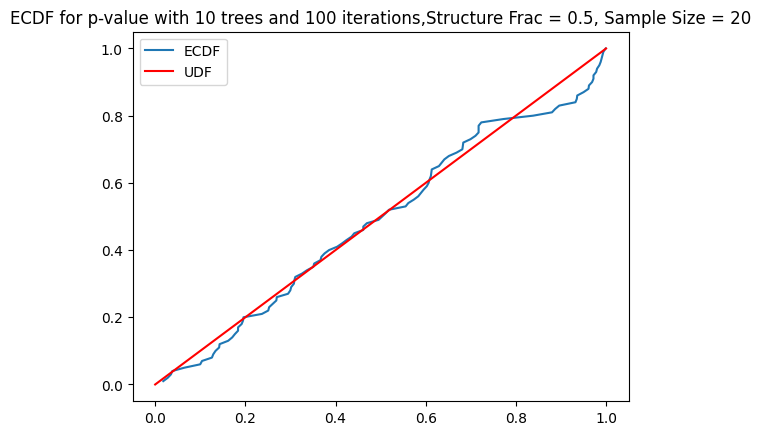

In [14]:
#pvalue = np.load("pvalue_w_all_1k.npy")
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(pvalues) 
plt.plot(ecdf.x, ecdf.y,label = "ECDF")
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),c = 'r',label = "UDF")
plt.title("ECDF for p-value with 10 trees and 100 iterations,Structure Frac = 0.5, Sample Size = 20")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Histogram for p-value with 10 trees and 100 iterations,Structure Frac = 0.5,Sample Size = 20')

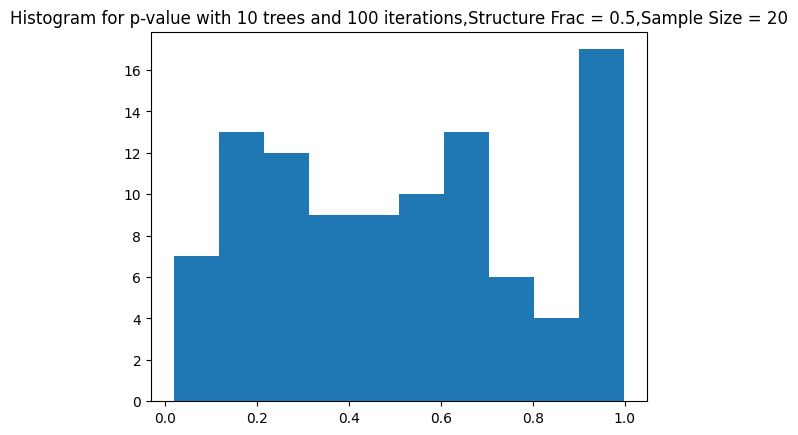

In [15]:
plt.hist(pvalues,bins=10)
plt.title("Histogram for p-value with 10 trees and 100 iterations,Structure Frac = 0.5,Sample Size = 20")